In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
ill = pd.read_csv("idsp.csv", encoding='latin1')  # or use 'ISO-8859-1' or 'cp1252' if needed
ill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6474 entries, 0 to 6473
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   year                    6474 non-null   int64 
 1   week                    6474 non-null   int64 
 2   outbreak_starting_date  6474 non-null   object
 3   reporting_date          5455 non-null   object
 4   state                   6474 non-null   object
 5   district                6473 non-null   object
 6   disease_illness_name    6469 non-null   object
 7   status                  6474 non-null   object
 8   cases                   6474 non-null   int64 
 9   deaths                  6474 non-null   int64 
 10  unit                    6474 non-null   object
 11  note                    6 non-null      object
dtypes: int64(4), object(8)
memory usage: 607.1+ KB


In [37]:
recent_ill = ill[ill['year'].isin([2023, 2024, 2025])]

In [38]:
top_diseases = (
    recent_ill
    .groupby(['state', 'disease_illness_name'])['cases']
    .sum()
    .reset_index()
    .sort_values(['state', 'cases'], ascending=[True, False])
)

top2_diseases = top_diseases.groupby('state').head(2)

In [39]:
aqi=pd.read_csv("aqi.csv")
aqi

,date,state,area,number_of_monitoring_stations,prominent_pollutants,aqi_value,air_quality_status,unit,note
0,30-04-2025,Maharashtra,Amravati,2,PM10,78,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN
1,30-04-2025,Bihar,Purnia,1,CO,56,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN
2,30-04-2025,Madhya Pradesh,Katni,1,O3,98,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN
3,30-04-2025,Chhattisgarh,Tumidih,1,PM10,103,Moderate,number_of_monitoring_stations in Absolute Numb...,NaN
4,30-04-2025,Assam,Byrnihat,1,PM2.5,61,Satisfactory,number_of_monitoring_stations in Absolute Numb...,NaN
...,...,...,...,...,...,...,...,...,...
235780,01-04-2022,Bihar,Arrah,1,PM10,210,Poor,number_of_monitoring_stations in Absolute Numb...,NaN
235781,01-04-2022,Rajasthan,Jaipur,3,"PM2.5,PM10",158,Moderate,number_of_monitoring_stations in Absolute Numb...,NaN
235782,01-04-2022,Maharashtra,Chandrapur,2,PM2.5,201,Poor,number_of_monitoring_stations in Absolute Numb...,NaN
235783,01-04-2022,Uttar Pradesh,Varanasi,4,PM10,128,Moderate,number_of_monitoring_stations in Absolute Numb...,NaN


In [40]:
# Step 1: Clean any invisible whitespace (just to be safe)
aqi['date'] = aqi['date'].astype(str).str.strip()

# Step 2: Convert using the exact format
aqi['date'] = pd.to_datetime(aqi['date'], format='%d-%m-%Y', errors='coerce')

# Step 4: Verify a few dates
print(aqi['date'].head())

0   2025-04-30
1   2025-04-30
2   2025-04-30
3   2025-04-30
4   2025-04-30
Name: date, dtype: datetime64[ns]


In [41]:
aqi_recent = aqi[aqi['date'].dt.year.isin([2023, 2024, 2025])]

In [42]:
avg_aqi = (
    aqi_recent
    .groupby('state')['aqi_value']
    .mean()
    .reset_index()
    .rename(columns={'aqi_value': 'average_aqi'})
)

In [43]:
# Standardize state names before merging
avg_aqi['state'] = avg_aqi['state'].str.strip().str.title()
top2_diseases['state'] = top2_diseases['state'].str.strip().str.title()


C:\Users\91935\AppData\Local\Temp\ipykernel_18060\1049939800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top2_diseases['state'] = top2_diseases['state'].str.strip().str.title()


In [44]:
final_df = top2_diseases.merge(avg_aqi, on='state', how='left')

In [45]:
final_df

,state,disease_illness_name,cases,average_aqi
0,Andaman And Nicobar Islands,Acute Diarrheal Disease,94,57.706897
1,Andaman And Nicobar Islands,Fever with Rash,8,57.706897
2,Andhra Pradesh,Acute Diarrheal Disease,3189,78.529013
3,Andhra Pradesh,Cholera,1081,78.529013
4,Arunachal,Rabies,1,NaN
...,...,...,...,...
70,Uttar Pradesh,Food Poisoning,2218,123.688452
71,Uttarakhand,Dengue,1092,88.100917
72,Uttarakhand,Acute Diarrheal Disease,626,88.100917
73,West Bengal,Acute Diarrheal Disease,3276,117.816071


In [46]:
# Group by disease, then aggregate
top_diseases = (
    final_df
    .groupby('disease_illness_name')
    .agg(
        total_cases=('cases', 'sum'),
        num_states=('state', 'nunique'),
        avg_aqi=('average_aqi', 'mean')
    )
    .sort_values('total_cases', ascending=False)
    .head(10)
    .reset_index()
)

# Display result
print(top_diseases)



      disease_illness_name  total_cases  num_states     avg_aqi
0  Acute Diarrheal Disease        68227          27  103.718765
1           Food Poisoning        23519          11   97.908485
2                  Cholera        10798           8  106.470311
3                   Dengue        10296           9  110.532154
4                  Malaria         5795           1  165.854725
5              Hepatitis A         1699           2  115.363043
6                    Mumps         1674           3   63.988158
7          Fever with Rash          838           2  105.484757
8                  Measles          622           2   73.540584
9               Chickenpox          325           2   73.540584


C:\Users\91935\AppData\Local\Temp\ipykernel_18060\564154613.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


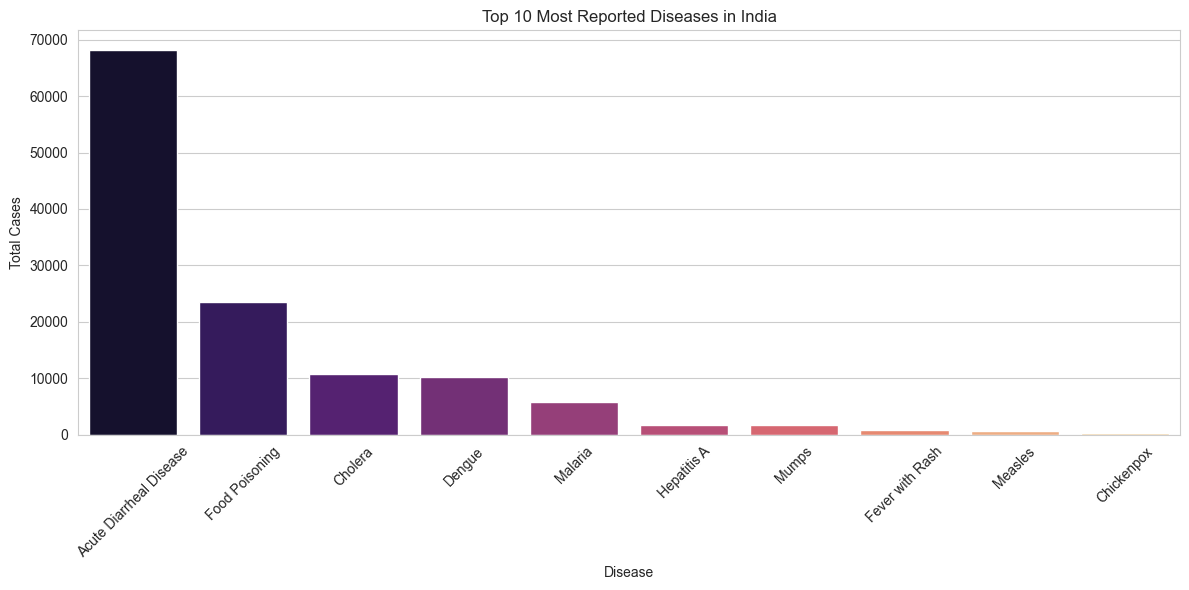

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_diseases,
    x='disease_illness_name',
    y='total_cases',
    palette='magma'
)
plt.title("Top 10 Most Reported Diseases in India")
plt.xlabel("Disease")
plt.ylabel("Total Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\91935\AppData\Local\Temp\ipykernel_18060\1691434041.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


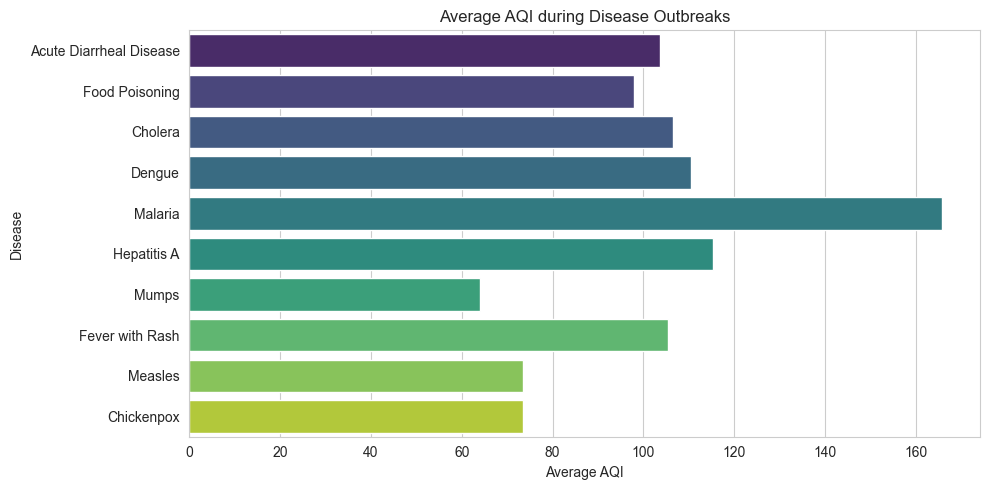

In [48]:
# Drop rows where AQI is NaN
aqi_plot = top_diseases.dropna(subset=['avg_aqi'])

plt.figure(figsize=(10, 5))
sns.barplot(
    data=aqi_plot,
    x='avg_aqi',
    y='disease_illness_name',
    palette='viridis'
)
plt.title("Average AQI during Disease Outbreaks")
plt.xlabel("Average AQI")
plt.ylabel("Disease")
plt.tight_layout()
plt.show()
